In [1]:
from google.colab import files
uploaded = files.upload()

Saving energydata_complete.csv to energydata_complete (2).csv


In [2]:
!pip install stable-baselines3[extra] gym numpy matplotlib

In [3]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

In [4]:
!pip install "gymnasium[box2d]" "shimmy" --upgrade

  Using cached Shimmy-2.0.0-py3-none-any.whl.metadata (3.5 kB)
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Using cached swig-4.3.1-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (3.5 kB)
Using cached swig-4.3.1-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.9 MB)
Using cached Shimmy-2.0.0-py3-none-any.whl (30 kB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (box2d-py)


In [5]:
import gymnasium as gym  # 🔄 Replace gym with gymnasium
from gymnasium import spaces

class SmartHomeEnv(gym.Env):
    def __init__(self):
        super(SmartHomeEnv, self).__init__()

        # Normalized state: [hour, price, current load]
        self.observation_space = spaces.Box(low=0, high=1, shape=(3,), dtype=np.float32)
        self.action_space = spaces.Discrete(3)

        self.current_hour = 0
        self.total_cost = 0
        self.steps = 0
        self.max_steps = 24

    def step(self, action):
        price = self._get_price(self.current_hour)
        load = self._get_load(action)

        reward = -price * load
        self.total_cost += price * load

        self.current_hour += 1
        self.steps += 1
        done = self.steps >= self.max_steps

        next_state = np.array([
            self.current_hour / 24,
            price,
            load
        ], dtype=np.float32)

        return next_state, reward, done, False, {}  # ✅ updated format

    def reset(self, seed=None, options=None):
        self.current_hour = 0
        self.total_cost = 0
        self.steps = 0

        return np.array([0, self._get_price(0), 1], dtype=np.float32), {}

    def _get_price(self, hour):
        if 18 <= hour < 21:
            return 1.0
        elif 8 <= hour < 18:
            return 0.6
        else:
            return 0.2

    def _get_load(self, action):
        if action == 1:
            return 0.5
        elif action == 2:
            return 0.3
        return 1.0


In [6]:
env = SmartHomeEnv()
check_env(env)


In [7]:
from stable_baselines3 import PPO

# Create the environment
env = SmartHomeEnv()

# Initialize the PPO model
model = PPO("MlpPolicy", env, verbose=1)

# Train the agent
model.learn(total_timesteps=10000)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24       |
|    ep_rew_mean     | -6.63    |
| time/              |          |
|    fps             | 687      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 24          |
|    ep_rew_mean          | -6.32       |
| time/                   |             |
|    fps                  | 379         |
|    iterations           | 2           |
|    time_elapsed         | 10          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011023983 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss   

Total energy cost (optimized): 3.9


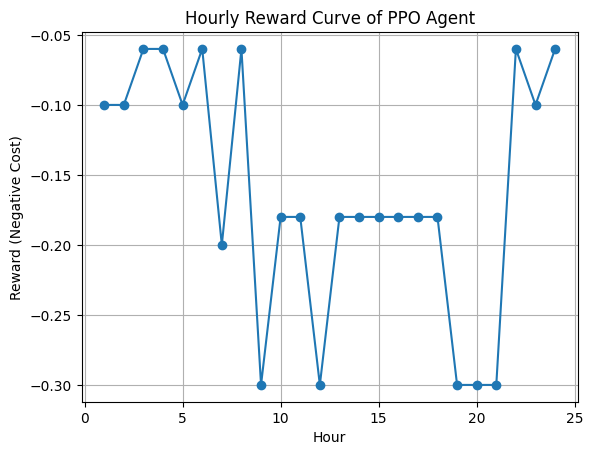

In [8]:
obs, _ = env.reset()
done = False
rewards = []
total_cost = 0
hours = []

while not done:
    action, _ = model.predict(obs)
    obs, reward, done, _, _ = env.step(action)
    rewards.append(reward)
    hours.append(env.current_hour)
    total_cost += -reward  # reward is negative cost

print("Total energy cost (optimized):", round(total_cost, 4))

# Plot reward per hour
plt.plot(hours, rewards, marker='o')
plt.xlabel("Hour")
plt.ylabel("Reward (Negative Cost)")
plt.title("Hourly Reward Curve of PPO Agent")
plt.grid(True)
plt.show()

In [9]:
env = SmartHomeEnv()
obs, _ = env.reset()
done = False
baseline_cost = 0

while not done:
    action = 0  # always use full load (worst case)
    obs, reward, done, _, _ = env.step(action)
    baseline_cost += -reward

print("Total energy cost (baseline):", round(baseline_cost, 4))


Total energy cost (baseline): 11.2


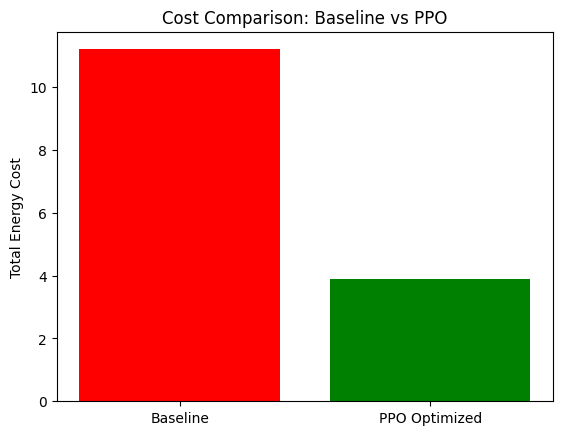

In [10]:
import matplotlib.pyplot as plt

plt.bar(["Baseline", "PPO Optimized"], [baseline_cost, total_cost], color=["red", "green"])
plt.ylabel("Total Energy Cost")
plt.title("Cost Comparison: Baseline vs PPO")
plt.show()


In [11]:
model.save("ppo_smart_grid_model")

In [12]:
from google.colab import files
files.download("ppo_smart_grid_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>